In [1]:
%cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from deap import tools, algorithms, creator, base, gp
import ea_utils
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import itertools
%load_ext autoreload

/home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn


In [4]:
# Use cpu for PRNG generation for speed-up
jax.config.update("jax_platform_name", "cpu") # If you change this, you have to restart the notebook
jax.default_backend()

'cpu'

In [5]:
data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

In [6]:
tamox_df = pd.read_csv(f"{data_dir}/tamoxBinaryEntrez.csv")
tamox_df.head()

,posOutcome,4111,4110,10661,131,4438,330,1109,2637,2642,...,7634,55769,7637,7644,741,54993,79364,7791,23140,26009
0,0,0,0,0,1,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0
1,1,1,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,0,1,0,1
2,0,0,0,0,1,0,0,1,1,1,...,0,0,0,1,1,0,0,1,0,0
3,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,0,1,1,1,1,...,0,0,0,1,1,0,0,1,0,0


In [7]:
X_df, y_df = tamox_df[tamox_df.columns.difference(["posOutcome"])], tamox_df["posOutcome"]

In [144]:
seed = 196
np.random.seed(seed)
rng_key = jax.random.PRNGKey(seed)

### Cosmic Genes

In [145]:
cosmic_genes_df = pd.read_csv(f"{data_dir}/cosmic_genes.csv")
cosmic_genes_df = cosmic_genes_df[~cosmic_genes_df["Entrez GeneId"].isnull()]
cosmic_genes_ids = cosmic_genes_df["Entrez GeneId"].astype(int)
cosmic_genes_ids = cosmic_genes_ids.to_list()
len(cosmic_genes_ids)

729

In [146]:
cols = X_df.columns.to_list()
cols = [int(c) for c in cols]
cosmic_intr = list(set(set(cosmic_genes_ids) & set(cols)))
cosmic_intr = [str(c) for c in cosmic_intr]
len(cosmic_intr)

497

In [147]:
X_cosmic = X_df.loc[:,cosmic_intr]

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True, stratify=y_df)
# Load the selected features
exp_dir = f"{data_dir}/exp_data_4/cancer/cosmic"
sel_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_70.npy")

In [149]:
X_train_sel, X_test_sel = X_train.iloc[:,sel_idx].to_numpy(), X_test.iloc[:,sel_idx].to_numpy()
# X_train_sel, X_test_sel = X_train_sel.astype(bool), X_test_sel.astype(bool)
n, p = X_train_sel.shape

### EA with DEAP

In [150]:
x_train, x_test = tuple(map(tuple, X_train_sel)), tuple(map(tuple, X_test_sel))

In [151]:
from sklearn.metrics import roc_auc_score, f1_score

def ea_fitness_fn(individual, x, pset):

    # Transform the tree expression into a callable function
    func = gp.compile(individual, pset)

    output = np.array([func(*x_train[i]) for i in range(len(x))]).astype(np.int32)
    # incorrect = np.sum((y_train != output).astype(np.float32))
    # return np.mean(accuracy),
    # return f1_score(y_train, output),
    return roc_auc_score(y_train, output), len(individual)
    # return -incorrect,

def get_ind_pred(ind, x, pset):
    func = gp.compile(ind, pset)

    output = np.array([func(*x[i]) for i in range(len(x))]).astype(np.int32)
    return output

def tree_similarity(ind1, ind2):
    # Function to measure the similarity of trees - we use fitness value to measure similairty
    fit_1, fit_2 = ind1.fitness.values[0], ind2.fitness.values[0]

    dist = np.abs(fit_1 - fit_2)

    return dist < 0.01

import networkx as nx
def draw_tree(ind):
    nodes, edges, labels = gp.graph(ind)

    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = nx.nx_pydot.graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)

In [152]:
import operator
# define new primitive set for strongly typed GP

# # logic operators
# # Define a new if-then-else function
def if_then_else(input, output1, output2):
  if input: return output1
  else: return output2

pset = gp.PrimitiveSetTyped("MAIN", itertools.repeat(bool, p), bool, "f")

pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)
pset.addPrimitive(if_then_else, [bool, bool, bool], bool)

# pset.addTerminal(False, bool)
# pset.addTerminal(True, bool)

In [153]:
%autoreload
import ea_utils

n_pop = 100
pop_keys = jax.random.split(rng_key, n_pop)

creator.create("FitnessMax", base.Fitness, weights=(1.0, -0.5))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", ea_utils.genHalfAndHalf, pset=pset, min_=1,  max_=3)
toolbox.register("individual", ea_utils.initIterate, container=creator.Individual, generator=toolbox.expr)
toolbox.register("population", ea_utils.initRepeat, pop_keys, list, toolbox.individual)

toolbox.register("evaluate", ea_fitness_fn, pset=pset, x=x_train)
# toolbox.decorate("evaluate", tools.DeltaPenalty(check_feasibility, -1, penalty_fn))
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", ea_utils.cxOnePoint)
toolbox.register("expr_mut", ea_utils.genFull, min_=0, max_=3)
toolbox.register("mutate", ea_utils.mutUniform, expr=toolbox.expr_mut, pset=pset)

/home/xabush/miniconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/xabush/miniconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [166]:
import time
from datetime import timedelta

stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

s_time = time.time()
pop = toolbox.population(n=n_pop)
CXPB, MUTPB = 0.5, 0.1
n_gen = 500
hof = tools.ParetoFront()
# hof = tools.HallOfFame(10)
final_pop, logbook = ea_utils.eaSimple(rng_key, pop, toolbox, CXPB, MUTPB, n_gen, stats=mstats, halloffame=hof)
e_time = time.time()

print(f"Elapsed: {timedelta(seconds=(e_time - s_time))}")

   	      	                                 fitness                                 	                      size                     
   	      	-------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std      	avg 	gen	max	min	nevals	std    
0  	500   	0.497068	0  	0.607194	0.401444	500   	0.0352536	4.11	0  	13 	2  	500   	2.25164
1  	500   	0.493463	1  	0.615666	0.378837	500   	0.0391015	4.11	1  	13 	2  	500   	2.11988
2  	500   	0.495853	2  	0.621315	0.378837	500   	0.0390168	4.11	2  	14 	2  	500   	2.07988
3  	500   	0.492961	3  	0.597834	0.384334	500   	0.0381257	4.11	3  	15 	2  	500   	2.07314
4  	0     	0.492961	4  	0.597834	0.384334	0     	0.0381257	4.11	4  	15 	2  	0     	2.07314
5  	500   	0.491853	5  	0.597834	0.384334	500   	0.0394239	4.11	5  	15 	2  	500   	2.07507
6  	0     	0.491853	6  	0.597834	0.384334	0     	0.0394239	4.11	6  	15 	2  	0     	2.07507
7  	50

In [167]:
len(hof)

6

In [168]:
train_preds = []
test_preds = []
i = 0
for ind in hof:
    train_pred = get_ind_pred(ind, x_train, pset)
    train_preds.append(train_pred)

    test_pred = get_ind_pred(ind, x_test, pset)
    test_preds.append(test_pred)

train_preds = np.array(train_preds).T
test_preds = np.array(test_preds).T

In [169]:
test_preds

array([[0, 0, 0, 0, 1, 1],
       [1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0],
       ...,
       [1, 0, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 1, 1]], dtype=int32)

In [170]:
from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc_score(y_train, np.mean(np.array(train_preds), axis=1))

0.7007852077001013

In [171]:
roc_auc_score(y_test, np.mean(np.array(test_preds), axis=1))

0.6189588511460922

In [172]:
X_train_comb, X_test_comb = np.concatenate([X_train_sel, train_preds], axis=1), \
                            np.concatenate([X_test_sel, test_preds], axis=1)

cv = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

In [173]:
from run_moses_cosmic_exp import run_logistc_regression
log_best_param_1, log_cv_score_1, log_test_score_1 = run_logistc_regression(X_train_comb, X_test_comb, y_train,
                                                                            y_test, cv)
print(f"Param: {log_best_param_1}, cv_score: {log_cv_score_1}, test_score: {log_test_score_1}")
clf_1 = LogisticRegression(max_iter=10000, **log_best_param_1)
clf_1.fit(X_train_comb, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Param: {'C': 0.046415888336127774}, cv_score: 0.705979020979021, test_score: 0.5763601215133942


LogisticRegression(C=0.046415888336127774, max_iter=10000)

In [174]:
%autoreload
from run_nn_cosmic_exp import run_logistic_regression
log_best_param_2, log_cv_score_2, log_test_score_2 = run_logistic_regression(X_train_sel, X_test_sel,
                                                                             y_train.to_numpy(), y_test.to_numpy(), cv)
print(f"Param: {log_best_param_2}, cv_score: {log_cv_score_2}, test_score: {log_test_score_2}")
clf_2 = LogisticRegression(max_iter=10000, **log_best_param_2)
clf_2.fit(X_train_sel, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Param: {'C': 0.1}, cv_score: 0.6831837606837607, test_score: 0.5618613642640156


LogisticRegression(C=0.1, max_iter=10000)

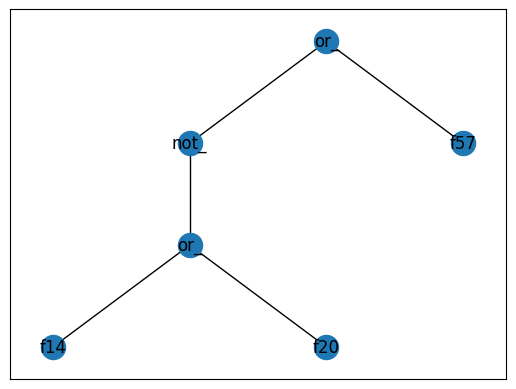

In [175]:
draw_tree(hof[0])

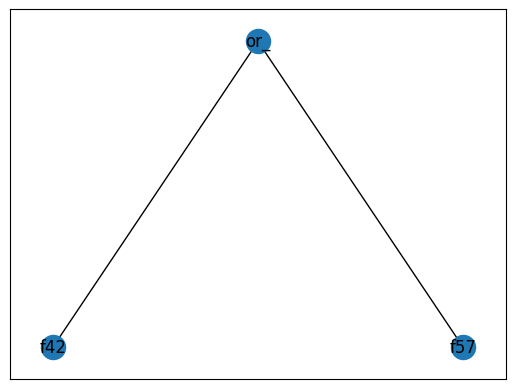

In [176]:
draw_tree(hof[2])

In [177]:
clf_1.coef_[0]

array([ 0.0298535 ,  0.02830636, -0.04447149, -0.11428677, -0.12783432,
        0.06283661, -0.05510451, -0.045344  ,  0.01443985,  0.02868002,
        0.00060317,  0.11555422,  0.04327593,  0.14548949, -0.11506167,
       -0.03762626,  0.03090464,  0.004889  ,  0.03792544,  0.02947108,
       -0.13484062,  0.03826022, -0.32750777, -0.19287167, -0.00618085,
        0.02802816,  0.11031892, -0.12913843,  0.01534247,  0.37455129,
       -0.26606369, -0.0066102 ,  0.01772661,  0.1006751 , -0.07956511,
       -0.13544815, -0.10525505, -0.20312589, -0.28705361,  0.14488861,
       -0.01835384, -0.02703042,  0.13217806,  0.16757589, -0.17982921,
       -0.06595559, -0.00749463,  0.06143239, -0.13627215, -0.08678363,
       -0.03519117, -0.1126093 , -0.00389541, -0.14794469,  0.17710613,
       -0.0964507 , -0.07201579,  0.20583684, -0.19350938, -0.08615082,
       -0.00888723,  0.05998014, -0.00844902, -0.03188612, -0.19304168,
       -0.04459463, -0.19296504,  0.0390817 , -0.02635944, -0.04

In [108]:
X_cosmic.iloc[:,sel_idx].iloc[:,[18, 56, 25]]

,4928,26511,2316
0,1,1,0
1,1,1,0
2,1,1,1
3,1,1,0
4,1,1,1
...,...,...,...
637,1,1,0
638,1,0,1
639,1,1,0
640,1,1,0


In [125]:
",".join([str(idx) for idx in np.argsort(np.abs(clf_1.coef_[0]))[::-1][:5]])

'70,23,73,71,38'

### Multiple runs with 70 features

In [127]:
exp_seeds = []
with open(f"{exp_dir}/deap/seeds_main.txt", "r") as fp:
    for line in fp.readlines():
        exp_seeds.append(int(line.strip()))

In [128]:
res_dfs = []

for seed in exp_seeds:
    res_df = pd.read_csv(f"{exp_dir}/deap/res_summary_cosmic_genes_deap_s_{seed}.csv")
    res_dfs.append(res_df)

len(res_dfs)

20

In [129]:
exp_res_df = pd.concat(res_dfs, axis=0)
exp_res_df

,seed,classifier,num_feats,top_5_feats,cv_score,test_score
0,422,BNN + DEAP,6,-,0.663510,0.573184
1,422,BNN + DEAP + LR,76,"71,29,72,5,17",0.751894,0.624551
0,261,BNN + DEAP,6,-,0.570707,0.622825
1,261,BNN + DEAP + LR,76,"70,72,71,66,36",0.641414,0.628003
0,968,BNN + DEAP,6,-,0.708333,0.600870
1,968,BNN + DEAP + LR,76,"55,7,10,14,71",0.725379,0.657139
0,282,BNN + DEAP,4,-,0.595644,0.655206
1,282,BNN + DEAP + LR,74,"23,70,10,38,72",0.601641,0.698840
0,739,BNN + DEAP,6,-,0.654040,0.660108
1,739,BNN + DEAP + LR,76,"70,72,71,74,16",0.734848,0.669981


In [209]:
exp_res_df.groupby(["classifier"])[["cv_score", "test_score", "num_feats"]].mean()

,cv_score,test_score,num_feats
classifier,,,
BNN + DEAP,0.638794,0.598409,4.65
BNN + DEAP + LR,0.704830,0.633996,74.65


In [204]:
%autoreload
from ea_train_cosmic import run_deap, run_logistc_regression
from nn_util import setup_logger
import datetime
import warnings

warnings.filterwarnings("ignore")

bnn_deap_dict = {"seed": [], "classifier": [], "num_feats": [], "top_5_feats": [] ,"cv_score": [], "test_score": []}

cxpb, mutpb = 0.5, 0.2
n_gen = 1000

num_feats = 70

for seed in exp_seeds:
    print(f"Running seed {seed}")
    logger = setup_logger(None, seed)
    start_time = time.time()

    rng_key = jax.random.PRNGKey(seed)
    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)

    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True,
                                                        stratify=y_df)
    # X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    # y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    selected_idx = np.load(f"{exp_dir}/bnn_sel_idx_s_{seed}_n_{num_feats}.npy")
    X_train_sel, X_test_sel = X_train.iloc[:,selected_idx].to_numpy(), X_test.iloc[:,selected_idx].to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_sel, y_train, random_state=seed, shuffle=True,
                                                              stratify=y_train, test_size=0.2)


    hof, val_score, test_score, train_preds, val_preds, test_preds = run_deap(rng_key, X_train_sel, X_val_sel, X_test_sel,
                                                                              y_train, y_val, y_test, cxpb, mutpb, n_gen, logger)

    X_train_sel_ea = np.concatenate([X_train_sel, train_preds], axis=1)
    X_val_sel_ea = np.concatenate([X_val_sel, val_preds], axis=1)
    X_test_sel_ea = np.concatenate([X_test_sel, test_preds], axis=1)

    clf_log, log_best_params, log_cv_score, log_test_score = run_logistc_regression(X_train_sel_ea, X_val_sel_ea, X_test_sel_ea,
                                                                                    y_train, y_val ,y_test, cv, logger)

    # Check the top 5 feats acc. Logistic Regression classifier
    top_5_feats = ",".join([str(idx) for idx in np.argsort(np.abs(clf_log.coef_[0]))[::-1][:5]])

    bnn_deap_dict["classifier"].append("DEAP")
    bnn_deap_dict["seed"].append(seed)
    bnn_deap_dict["num_feats"].append(num_feats)
    bnn_deap_dict["cv_score"].append(val_score)
    bnn_deap_dict["test_score"].append(test_score)
    bnn_deap_dict["top_5_feats"].append("-")

    bnn_deap_dict["classifier"].append("DEAP + LR")
    bnn_deap_dict["seed"].append(seed)
    bnn_deap_dict["num_feats"].append(num_feats + len(hof))
    bnn_deap_dict["cv_score"].append(log_cv_score)
    bnn_deap_dict["test_score"].append(log_test_score)
    bnn_deap_dict["top_5_feats"].append(top_5_feats)

    end_time = time.time()

    elapsed = datetime.timedelta(seconds=(end_time - start_time))
    logger.info(f"Done for seed {seed}. Time elapsed - {elapsed}")

bnn_deap_df = pd.DataFrame(bnn_deap_dict)
bnn_deap_df

Running seed 422
   	      	                                 fitness                                 	                      size                     
   	      	-------------------------------------------------------------------------	-----------------------------------------------
gen	nevals	avg     	gen	max     	min     	nevals	std      	avg 	gen	max	min	nevals	std    
0  	100   	0.348915	0  	0.558856	0.150151	100   	0.0969557	3.95	0  	11 	2  	100   	2.17428
1  	60    	0.352107	1  	0.51818 	0.116366	60    	0.101969 	4.18	1  	12 	1  	60    	2.36804
2  	59    	0.349152	2  	0.519407	0       	59    	0.108084 	4.62	2  	13 	1  	59    	2.57984
3  	69    	0.352979	3  	0.522933	0       	69    	0.10857  	4.83	3  	16 	1  	69    	2.74975
4  	54    	0.365983	4  	0.522933	0.0956511	54    	0.0952846	5.02	4  	16 	1  	54    	2.78201
5  	62    	0.3633  	5  	0.535884	0.0862643	62    	0.10507  	5.15	5  	16 	1  	62    	2.97447
6  	50    	0.366883	6  	0.535884	0.0862643	50    	0.10723  	5.37	6  	17 	1  	5

,seed,classifier,num_feats,top_5_feats,cv_score,test_score
0,422,DEAP,70,-,0.716540,0.607705
1,422,DEAP + LR,78,"76,29,33,70,2",0.732955,0.631455
2,261,DEAP,70,-,0.578914,0.567039
3,261,DEAP + LR,73,"72,66,70,64,36",0.628788,0.623999
4,968,DEAP,70,-,0.686237,0.538111
5,968,DEAP + LR,73,"55,7,64,70,10",0.724747,0.642778
6,282,DEAP,70,-,0.579230,0.623861
7,282,DEAP + LR,72,"23,38,10,70,40",0.575126,0.680889
8,739,DEAP,70,-,0.694760,0.641743
9,739,DEAP + LR,73,"70,18,10,16,71",0.751263,0.668186


In [215]:
bnn_deap_df.groupby(["classifier"])[["cv_score", "test_score", "num_feats"]].mean()

,cv_score,test_score,num_feats
classifier,,,
DEAP,0.606187,0.576481,70.0
DEAP + LR,0.701673,0.630482,73.5


In [201]:
bnn_feat_len_svm_df = pd.read_csv(f"{exp_dir}/moses/bnn_cosmic_feat_len_svm.csv")

In [213]:
%autoreload
from ea_train_cosmic import run_deap, run_logistc_regression
from nn_util import setup_logger
import datetime
import warnings

warnings.filterwarnings("ignore")

bnn_feat_len_deap_dict = {"seed": [], "classifier": [], "num_feats": [], "top_5_feats": [] ,"cv_score": [], "test_score": [], "kernel": []}

cxpb, mutpb = 0.5, 0.2
n_gen = 1000

for seed in exp_seeds:
    print(f"Running seed {seed}")
    logger = setup_logger(None, seed)
    start_time = time.time()

    rng_key = jax.random.PRNGKey(seed)
    cv = StratifiedKFold(random_state=seed, shuffle=True, n_splits=5)
    gamma_means = np.load(f"{exp_dir}/bnn_disc_mean_s_{seed}.npy")
    gamma_means_idx_s = np.argsort(gamma_means)[::-1]
    X_train, X_test, y_train, y_test = train_test_split(X_cosmic, y_df, test_size=0.3, random_state=seed, shuffle=True,
                                                        stratify=y_df)
    # X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    # y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    feat_len = bnn_feat_len_svm_df[bnn_feat_len_svm_df["seed"] == seed]["num_feats"].iloc[0]
    kernel = bnn_feat_len_svm_df[bnn_feat_len_svm_df["seed"] == seed]["kernel"].iloc[0]
    gamma_idx = gamma_means_idx_s[:feat_len]
    X_train_sel, X_test_sel = X_train.iloc[:,gamma_idx].to_numpy(), X_test.iloc[:,gamma_idx].to_numpy()
    y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

    X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_sel, y_train, random_state=seed, shuffle=True,
                                                              stratify=y_train, test_size=0.2)


    hof, val_score, test_score, train_preds, val_preds, test_preds = run_deap(rng_key, X_train_sel, X_val_sel, X_test_sel,
                                                                              y_train, y_val, y_test, cxpb, mutpb, n_gen, logger)

    X_train_sel_ea = np.concatenate([X_train_sel, train_preds], axis=1)
    X_val_sel_ea = np.concatenate([X_val_sel, val_preds], axis=1)
    X_test_sel_ea = np.concatenate([X_test_sel, test_preds], axis=1)

    clf_log, log_best_params, log_cv_score, log_test_score = run_logistc_regression(X_train_sel_ea, X_val_sel_ea, X_test_sel_ea,
                                                                                    y_train, y_val ,y_test, cv, logger)

    # Check the top 5 feats acc. Logistic Regression classifier
    top_5_feats = ",".join([str(idx) for idx in np.argsort(np.abs(clf_log.coef_[0]))[::-1][:5]])

    bnn_feat_len_deap_dict["classifier"].append("DEAP")
    bnn_feat_len_deap_dict["seed"].append(seed)
    bnn_feat_len_deap_dict["num_feats"].append(feat_len)
    bnn_feat_len_deap_dict["cv_score"].append(val_score)
    bnn_feat_len_deap_dict["test_score"].append(test_score)
    bnn_feat_len_deap_dict["kernel"].append(kernel)
    bnn_feat_len_deap_dict["top_5_feats"].append("-")

    bnn_feat_len_deap_dict["classifier"].append("DEAP + LR")
    bnn_feat_len_deap_dict["seed"].append(seed)
    bnn_feat_len_deap_dict["num_feats"].append(feat_len + len(hof))
    bnn_feat_len_deap_dict["cv_score"].append(log_cv_score)
    bnn_feat_len_deap_dict["test_score"].append(log_test_score)
    bnn_feat_len_deap_dict["kernel"].append(kernel)
    bnn_feat_len_deap_dict["top_5_feats"].append(top_5_feats)

    end_time = time.time()

    elapsed = datetime.timedelta(seconds=(end_time - start_time))
    logger.info(f"Done for seed {seed}. Time elapsed - {elapsed}")

bnn_feat_len_deap_df = pd.DataFrame(bnn_feat_len_deap_dict)
bnn_feat_len_deap_df

Running seed 422
2022-10-25 22:03:28,987 [INFO], Num models: 7, EA Validation Score: 0.5852272727272728, Test Score: 0.5755316210991439
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-10-25 22:03:32,749 [INFO], LR best params {'C': 0.021544346900318832}
2022-10-25 22:03:32,778 [INFO], LR scores - cv score:  0.7393, test_score:  0.6182
2022-10-25 22:03:32,780 [INFO], Done for seed 422. Time elapsed - 0:00:39.034217
Running seed 261
2022-10-25 22:03:58,910 [INFO], Num models: 7, EA Validation Score: 0.5618686868686869, Test Score: 0.5367301850317592
Fitting 5 folds for each of 10 candidates, totalling 50 fits
2022-10-25 22:04:00,875 [INFO], LR best params {'C': 0.1}
2022-10-25 22:04:00,895 [INFO], LR scores - cv score:  0.5997, test_score:  0.6130
2022-10-25 22:04:00,897 [INFO], Done for seed 261. Time elapsed - 0:00:28.114843
Running seed 968
2022-10-25 22:05:01,988 [INFO], Num models: 5, EA Validation Score: 0.660669191919192, Test Score: 0.5478458989229494
Fitting 5 

,seed,classifier,num_feats,top_5_feats,cv_score,test_score,kernel
0,422,DEAP,90,-,0.585227,0.575532,poly
1,422,DEAP + LR,97,"93,95,29,35,5",0.739268,0.618199,poly
2,261,DEAP,100,-,0.561869,0.536730,poly
3,261,DEAP + LR,107,"100,102,101,89,70",0.599747,0.612952,poly
4,968,DEAP,90,-,0.660669,0.547846,rbf
5,968,DEAP + LR,95,"59,24,91,92,23",0.695076,0.608395,rbf
6,282,DEAP,50,-,0.601641,0.642916,rbf
7,282,DEAP + LR,53,"50,22,10,24,52",0.607955,0.698288,rbf
8,739,DEAP,100,-,0.628788,0.576084,rbf
9,739,DEAP + LR,104,"101,12,79,18,100",0.732955,0.586164,rbf


In [214]:
bnn_feat_len_deap_df.groupby(["classifier"])[["num_feats", "cv_score", "test_score"]].mean()

,num_feats,cv_score,test_score
classifier,,,
DEAP,77.00,0.602494,0.575846
DEAP + LR,81.25,0.703851,0.627182


In [194]:
bnn_feat_len_deap_df[(bnn_feat_len_deap_df["kernel"] != "linear") & (bnn_feat_len_deap_df["classifier"] == "DEAP + LR")][["cv_score", "test_score"]].mean()

cv_score      0.696378
test_score    0.635693
dtype: float64

In [ ]:
bnn_feat_len_deap_df[(bnn_feat_len_deap_df["kernel"] != "linear") & (bnn_feat_len_deap_df["classifier"] == "DEAP + LR")][["cv_score", "test_score"]].mean()